# Evaluating the effect of fault reactivation in maximum storage capacity of geological carbon storage projects

Jose Ubillus
## Proposed steps
1. Calculate effective vertical and horizontal stresses
2. Either estimate pore pressure assuming hydrostatic pressure or digitized data from Ringrose and Meckel (2019)
3. Generate 30 set of faults (depth, dip, strike) (random sampling or normal distribution)
5. Plot 4 failure lines (range: 0.3-0.6)
4. Plot normalized effective stress (Mohr) of the current state of stress of the domain 
5. Calculate Pmax from Ringrose and Meckel (2019)
6. Plot new state of stress after fluid injection (Any faults prone to reactivation?)
7. Estimate CO2 volume using Ringrose and Meckel equation with no fault reactivation (90% of Pmax), if present reduce Pmax to avoid fault reactivation. Use the data from the paper
8. Compare all scenarios and calculate the decrease in storage capacity if faults are prone to reactivation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scienceplots
plt.style.use(['science','no-latex'])

In [3]:
# Functions
def get_rotated_geographical_system(pstress,a,b,g):
    'Function takes angles in radians and returns rotation matrix'
    rpg = np.array([[np.cos(a)*np.cos(b),np.sin(a)*np.cos(b),-np.sin(b)],
                    [np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g),np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g),np.cos(b)*np.sin(g)],
                    [np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g),np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g),np.cos(b)*np.cos(g)]])
    
    rpg = np.round(rpg,2)
    
    # Multiply rotation matrix by principal stresses
    Sg = rpg.T @ pstress @ rpg

    return Sg

def computedf_strike_dip_stress(df):
    'Function takes strike and dip angles in degrees and returns effective normal and shear stress'
    # Degress to radians
    s = np.deg2rad(df.Str_angle)
    d = np.deg2rad(df.Dip_angle.astype(float))
    
    Sn_list = []
    tau_list = []
    for i in range(len(s)):
        sg = np.array([[df.SigmaH[i],0,0],[0,df.Sigmah[i],0],[0,0,df.SigmaV[i]]])
        nn = np.array([[-np.sin(s[i])*np.sin(d[i])],[np.cos(s[i])*np.sin(d[i])],[-np.cos(d[i])]])
        ns = np.array([[np.cos(s[i])],[np.sin(s[i])],[0]])
        nd = np.array([[-np.sin(s[i])*np.cos(d[i])],[np.cos(s[i])*np.cos(d[i])],[np.sin(d[i])]])

        t = sg @ nn

        Sn = np.dot(t.T,nn)
        ts = np.dot(t.T,ns)
        td = np.dot(t.T,nd)
        tau = np.sqrt(ts**2+td**2)

        Sn_list.append(Sn)
        tau_list.append(tau)

    return np.array(Sn_list),np.array(tau_list)

def normalized_mohr_circle(df):
    # Sort stresses in descending order
    sorted_stresses = np.array(sorted([df.Sigmah[0],df.SigmaH[0],df.SigmaV[0]],reverse=True))
    # Normalized stresses by vertical stress
    sorted_stresses = sorted_stresses/df.SigmaV[0]

    # Calculate center of the Mohr circle
    c1 = (sorted_stresses[0]+sorted_stresses[1])/2
    r1 = (sorted_stresses[0]-sorted_stresses[1])/2

    c2 = (sorted_stresses[1]+sorted_stresses[2])/2
    r2 = (sorted_stresses[1]-sorted_stresses[2])/2

    c3 = (sorted_stresses[0]+sorted_stresses[2])/2
    r3 = (sorted_stresses[0]-sorted_stresses[2])/2

    # Calculate Mohr circle 
    sp1 = np.linspace(sorted_stresses[0],sorted_stresses[1],1000)
    sp2 = np.linspace(sorted_stresses[1],sorted_stresses[2],1000)
    sp3 = np.linspace(sorted_stresses[0],sorted_stresses[2],1000)

    # Calculate y for Mohr circle
    yp1 = np.sqrt(r1**2-(sp1-c1)**2)
    yp2 =   np.sqrt(r2**2-(sp2-c2)**2)
    yp3 =   np.sqrt(r3**2-(sp3-c3)**2)

    return sp1,sp2,sp3,yp1,yp2,yp3

def normalized_tau_sn(tau,sn,vertical_stress):
    'Function takes shear and normal stress and returns normalized shear and normal stress'
    tau_norm = tau.flatten()/vertical_stress
    sn_norm = sn.flatten()/vertical_stress
    
    return tau_norm,sn_norm

def slip_tendency_classifier(sn,tau,u):
    '''
        u = friction coefficient, np.array
    '''
    ratio = tau/sn
    slip = {}
    for i in u:
        slip[i] = np.where(ratio>i,1,0)

    return slip


1. Generate 30 set of faults (depth, dip, strike) using a normal distribution

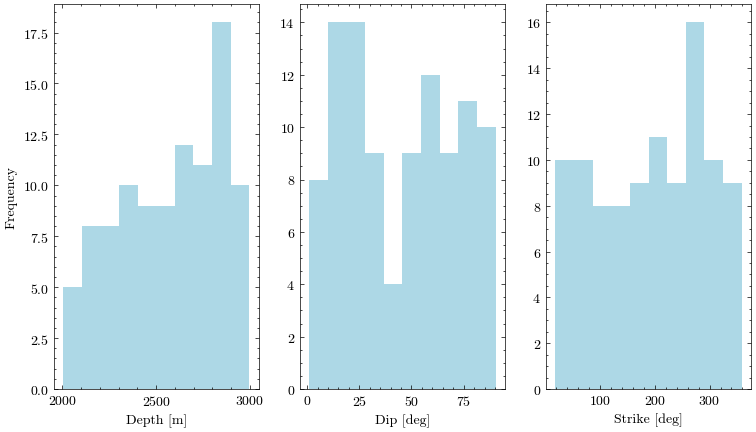

In [4]:
# Generate depths ranging from 1000 - 3000 m, zone of interest
depth = np.random.uniform(2000,3000,100)
# Generate dip and strike angles, using as reference WP2
strike = np.random.uniform(0,361,100)
dip = np.random.uniform(0,91,100)

# Plot the distribution of faults in the zone of interest
fig,ax = plt.subplots(1,3,figsize=(9,5))
ax[0].hist(depth,color='lightblue')
ax[0].set_xlabel('Depth [m]')
ax[0].set_ylabel('Frequency')
ax[1].hist(dip,color='lightblue')
ax[1].set_xlabel('Dip [deg]')
ax[2].hist(strike,color='lightblue')
ax[2].set_xlabel('Strike [deg]')
plt.show()

2. Compute stress regime for each fault

In [32]:
# Compute stress regime for each fault (sigmav, sigmaH, sigmah)
pore_pressure = 9.95 *depth/1000
# mu changes with depth according to Ringrose 
mu = 0.3
Sv = 22.25 * depth/1000
sv = Sv - pore_pressure
sH = mu/(1-mu) * sv
sh = sH
# 2*mu/(1-mu) * (sv-pore_pressure) # Pfrac criterion WRONG!
# Build dataframe with stress, depth and angles
df = pd.DataFrame()
df['Depth'] = depth
df['SigmaV'] = sv
df['SigmaH'] = sH
df['Sigmah'] = sh
df['Pp'] = pore_pressure
df['Dip_angle'] = dip
df['Str_angle'] = strike

# Compute geographical rotated stress regime for alpha = 0 , beta = 90, gamma = 0
alpha = 0
beta = np.deg2rad(90)
gamma = 0
# Compute rotation matrix
Sp = np.array([[df.SigmaV[0],0,0],[0,df.SigmaH[0],0],[0,0,df.Sigmah[0]]])
sg = get_rotated_geographical_system(Sp,alpha,beta,gamma)
# Compute effective normal and shear stress
Sn,tau = computedf_strike_dip_stress(df)
print(sg)

[[15.22044143  0.          0.        ]
 [ 0.         15.22044143  0.        ]
 [ 0.          0.         35.51436335]]


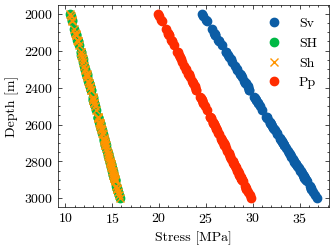

In [33]:
plt.plot(sv,depth,'o',label='Sv')
plt.plot(sH,depth,'o',label='SH')
plt.plot(sh,depth,'x',label='Sh')
plt.plot(pore_pressure,depth,'o',label='Pp')
plt.legend()
plt.xlabel('Stress [MPa]')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.show()

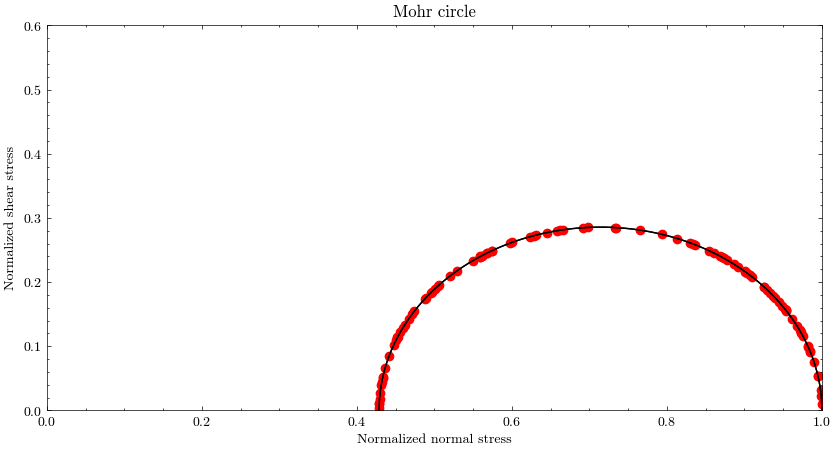

In [34]:
# Plot current state of stress without taking into account
sp1,sp2,sp3,yp1,yp2,yp3 = normalized_mohr_circle(df)
tau_norm,sn_norm = normalized_tau_sn(tau,Sn,df.SigmaV)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(sp1,yp1,color='black')
ax.plot(sp2,yp2,color='black')
ax.plot(sp3,yp3,color='black')
ax.scatter(sn_norm,tau_norm,color='red')
ax.set_xlabel('Normalized normal stress')
ax.set_ylabel('Normalized shear stress')
ax.set_title('Mohr circle')
ax.set_xlim([0,1])
ax.set_ylim([0,0.6])
plt.show()

3. Base case: No faults prone to reactivation 
If no faults are prone to reactivation, fluid can be injected as $\Delta$ P reaches the fracture pressure.

Let's assume that hear and estimate average Pfrac to estimate maximum $\Delta$ P

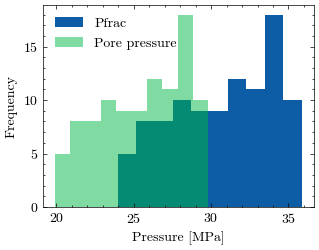

In [35]:
Pfrac = 2*mu/(1-mu) * (sv-pore_pressure)  + pore_pressure
deltaP = Pfrac - pore_pressure

plt.hist(Pfrac,label='Pfrac')
plt.hist(pore_pressure,label='Pore pressure',alpha=0.5)
plt.xlabel('Pressure [MPa]')
plt.ylabel('Frequency')
plt.legend()
plt.show()

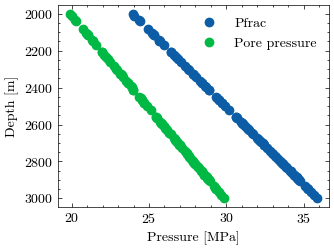

In [36]:
# Pfrac and pore pressure vs depth
plt.plot(Pfrac,depth,'o',label='Pfrac')
plt.plot(pore_pressure,depth,'o',label='Pore pressure')
plt.legend()
plt.xlabel('Pressure [MPa]')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.show()

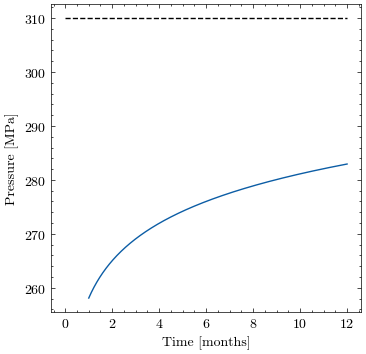

Volume injected [ton]: 280611.04476130527


In [37]:
# Let's assume that we are injecting with 6.5 MPa or 65 bars of overpressure and that the initial pressure is 290 bar. Therefore,
# my injection pressure is 355 bar. I will assume that the injection pressure is constant over time.

Pwell = 310 #MPA
pinit = 250 #MPA
A = 20
Ic = 40 #m3/day/bar
td = np.linspace(1,12,1000)
Pd = 0.5*np.log(4*td/1.781)
pres = pinit + A*Pd
# Plot pd vs td
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(td,pres)
ax.hlines(Pwell,0,12,linestyle='--',color='black')
ax.set_xlabel('Time [months]')
ax.set_ylabel('Pressure [MPa]')
plt.show()

# Estimate volume injected
Vp = Ic*(Pwell-pinit+sp.integrate.trapezoid(A*Pd,td))

Vt = 365/12*Vp *684 /1000
print('Volume injected [ton]:',Vt)

4. Fault reactivation scenario, injection pressure moves the Mohr circles to the left. Risk of fault reactivation

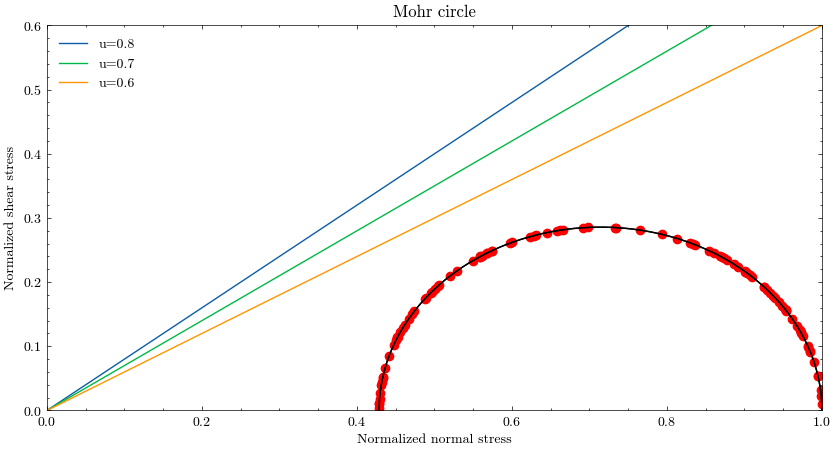

In [38]:
#Plot same Mohr circle with multple friction coefficients lines
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(sp1,yp1,color='black')
ax.plot(sp2,yp2,color='black')
ax.plot(sp3,yp3,color='black')
ax.scatter(sn_norm,tau_norm,color='red')
ax.plot(np.linspace(0,1,100),0.8*np.linspace(0,1,100),label='u=0.8')
ax.plot(np.linspace(0,1,100),0.7*np.linspace(0,1,100),label='u=0.7')
ax.plot(np.linspace(0,1,100),0.6*np.linspace(0,1,100),label='u=0.6')
ax.set_xlabel('Normalized normal stress')
ax.set_ylabel('Normalized shear stress')
ax.set_title('Mohr circle')
ax.set_xlim([0,1])
ax.set_ylim([0,0.6])
ax.legend()
plt.show()

Pressure increase using Pfrac from paper

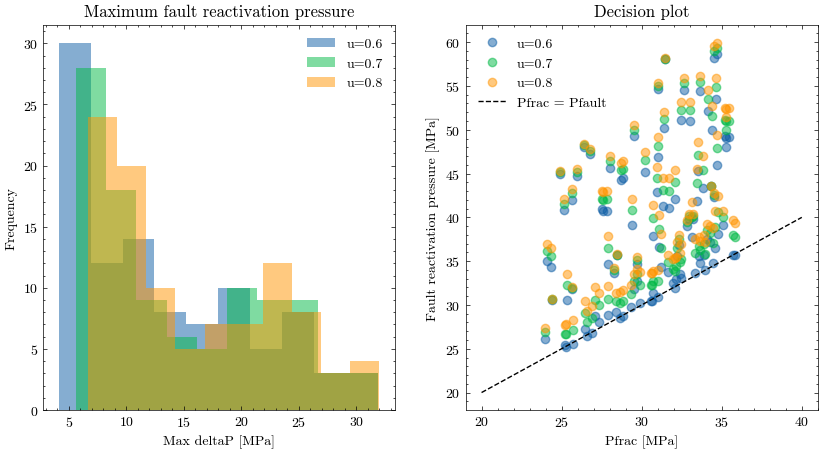

In [39]:
# horizontal distance max deltaP approach
#Failure line u = 0.6
plt.figure(figsize=(10,5))
us = [0.6,0.7,0.8]
for u in us:
    # Compute normal stress at failure
    sn_failure = tau_norm/u
    
    # Compute horizontal distance
    norm_diff = sn_norm-sn_failure
    # Compute max pressure
    max_deltaP = norm_diff*df.SigmaV
    
    plt.subplot(1,2,1)
    plt.hist(max_deltaP,label='u='+str(u),alpha=0.5)
    plt.xlabel('Max deltaP [MPa]')
    plt.ylabel('Frequency')
    plt.title('Maximum fault reactivation pressure')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(Pfrac,pore_pressure+max_deltaP,'o',label='u='+str(u),alpha=0.5)
   
    plt.ylabel('Fault reactivation pressure [MPa]')
    plt.xlabel('Pfrac [MPa]')
    plt.title('Decision plot')
    

plt.plot([20,40],[20,40],linestyle='--',color='black',label='Pfrac = Pfault')
plt.legend()
plt.show()

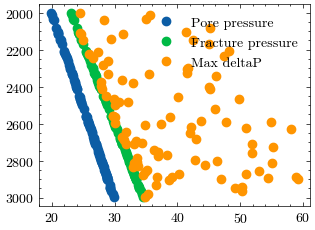

In [16]:
# Plot pore pressure, fracture pressure and max deltaP vs depth
plt.plot(pore_pressure,depth,'o',label='Pore pressure')
plt.plot(Pfrac,depth,'o',label='Fracture pressure')
plt.plot(pore_pressure+max_deltaP,depth,'o',label='Max deltaP')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [ ]:
# Maximum deltaP
def displacement_mohr_circle(safety_factor):

    deltaP = safety_factor*(2*mu/(1-mu)*(sv-pore_pressure))
    max_df = pd.DataFrame()
    sn = Sn.flatten() - deltaP
    tau_dis = tau.flatten()
    max_df['SigmaV'] = df.SigmaV - deltaP
    max_df['SigmaH'] = df.SigmaH - deltaP
    max_df['Sigmah'] = df.Sigmah - deltaP

    return max_df,sn,tau_dis

max_df,sn,tau = displacement_mohr_circle(1)
sp1,sp2,sp3,yp1,yp2,yp3 = normalized_mohr_circle(max_df)
tau_norm,sn_norm = normalized_tau_sn(tau,sn,max_df.SigmaV)
slip = slip_tendency_classifier(sn,tau,[0.8,0.7,0.6])

In [ ]:
#Plot same Mohr circle with multple friction coefficients lines
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(sp1,yp1,color='black')
ax.plot(sp2,yp2,color='black')
ax.plot(sp3,yp3,color='black')
ax.scatter(sn_norm,tau_norm,c=slip[0.8],cmap='jet')
ax.scatter(sn_norm,tau_norm,c=slip[0.7],cmap='jet')
ax.scatter(sn_norm,tau_norm,c=slip[0.6],cmap='jet')
ax.plot(np.linspace(0,1,100),0.8*np.linspace(0,1,100),label='u=1')
ax.plot(np.linspace(0,1,100),0.7*np.linspace(0,1,100),label='u=0.9')
ax.plot(np.linspace(0,1,100),0.6*np.linspace(0,1,100),label='u=0.8')
ax.set_xlabel('Normalized normal stress')
ax.set_ylabel('Normalized shear stress')
ax.set_title('Mohr circle')
ax.set_xlim([0,1])
ax.set_ylim([0,0.6])
ax.legend()
plt.show()

From the above, we see that if we inject the fluid at $\delta$ P with Pfrac as suggested, many faults from the proposed will be prone to reactivation. This analysis suggests that we should consider a safety factor to avoid fault reactivation

In [ ]:
# Calculate new deltaP with safety factor of 2.2
max_df,sn,tau = displacement_mohr_circle(0.6)
sp1,sp2,sp3,yp1,yp2,yp3 = normalized_mohr_circle(max_df)
tau_norm,sn_norm = normalized_tau_sn(tau,sn,max_df.SigmaV)
slip = slip_tendency_classifier(sn,tau,[0.8,0.7,0.6])

#Plot same Mohr circle with multple friction coefficients lines
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(sp1,yp1,color='black')
ax.plot(sp2,yp2,color='black')
ax.plot(sp3,yp3,color='black')
ax.scatter(sn_norm,tau_norm,c=slip[0.8],cmap='jet')
ax.scatter(sn_norm,tau_norm,c=slip[0.7],cmap='jet')
ax.scatter(sn_norm,tau_norm,c=slip[0.6],cmap='jet')
ax.plot(np.linspace(0,1,100),.8*np.linspace(0,1,100),label='u=0.8')
ax.plot(np.linspace(0,1,100),0.7*np.linspace(0,1,100),label='u=0.7')
ax.plot(np.linspace(0,1,100),0.6*np.linspace(0,1,100),label='u=0.6')
ax.set_xlabel('Normalized normal stress')
ax.set_ylabel('Normalized shear stress')
ax.set_title('Mohr circle')
ax.set_xlim([0,1])
ax.set_ylim([0,0.6])
ax.legend()
plt.show()

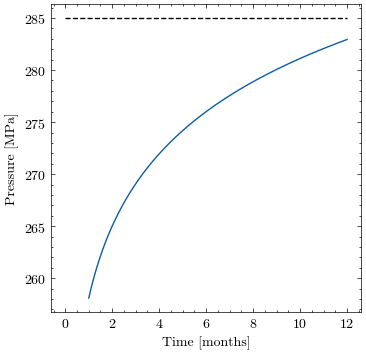

Volume injected [ton]: 259806.04476130527


In [42]:
# Let's say we only consider faults with friction coefficient of 1, our Pfrac should be reduce by a factor of 20 bar
# Now let's estimate the new storage capacity
Pwell = 285 #MPA
pinit = 250 #MPA
A = 20
Ic = 40 #m3/day/bar
td = np.linspace(1,12,1000)
Pd = 0.5*np.log(4*td/1.781)
pres = pinit + A*Pd
# Plot pd vs td
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(td,pres)
ax.hlines(Pwell,0,12,linestyle='--',color='black')
ax.set_xlabel('Time [months]')
ax.set_ylabel('Pressure [MPa]')
plt.show()

# Estimate volume injected
Vp = Ic*(Pwell-pinit+sp.integrate.trapezoid(A*Pd,td))

Vt = 365/12*Vp *684 /1000
print('Volume injected [ton]:',Vt)

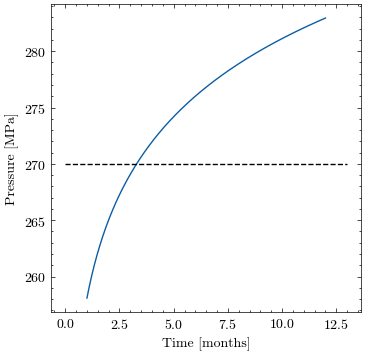

Volume injected [ton]: 61830.76119032632


In [23]:
# Let's say we only consider faults with friction coefficient of 1, our Pfrac should be reduce by a factor of 20 bar
# Now let's estimate the new storage capacity
Pwell = 270 #MPA
pinit = 250 #MPA
A = 20
Ic = 40 #m3/day/bar
td = np.linspace(1,12,1000)
Pd = 0.5*np.log(4*td/1.781)
pres = pinit + A*Pd
# Plot pd vs td
fig,ax = plt.subplots(figsize=(4,4))
ax.plot(td,pres)
ax.hlines(Pwell,0,13,linestyle='--',color='black')
ax.set_xlabel('Time [months]')
ax.set_ylabel('Pressure [MPa]')
plt.show()

# Estimate volume injected
Vp = Ic*(Pwell-pinit+sp.integrate.trapezoid(A*Pd,td))

Vt = 365/12*Vp *684 /1000
print('Volume injected [ton]:',Vt)

In [ ]:
# Bar plots of Mton injected vs cases
storage = [0.49,0.36,0.2]
cases = ['No faults','u=1','u=0.8']
plt.bar(cases,storage,color='lightblue')
plt.ylabel('CO2 Storage [Mton/year]')
plt.show()
